Sphere     | best fitness = 3.359504e-01
Rastrigin  | best fitness = 6.363503e+00
Rosenbrock | best fitness = 8.219992e+00
Ackley     | best fitness = 9.461592e-01


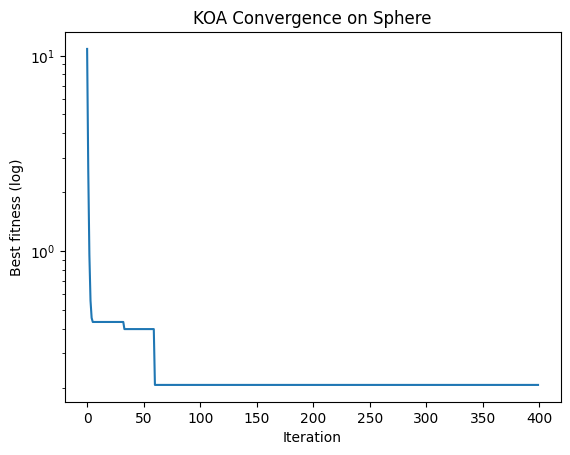

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# ------------------ Benchmark Functions ------------------

def sphere(x):
    return np.sum(x**2)

def rastrigin(x):
    A = 10.0
    return A * x.size + np.sum(x**2 - A * np.cos(2*pi*x))

def rosenbrock(x):
    return np.sum(100.0*(x[1:] - x[:-1]**2)**2 + (x[:-1]-1.0)**2)

def ackley(x):
    a, b, c = 20.0, 0.2, 2*np.pi
    n = x.size
    return -a*np.exp(-b*np.sqrt(np.sum(x**2)/n)) \
           - np.exp(np.sum(np.cos(c*x))/n) + a + np.e

# add more later if needed (20+ test functions)

# ------------------ Utility Functions ------------------

def clip_bounds(x, lb, ub):
    return np.minimum(np.maximum(x, lb), ub)

def unit_random(dim):
    v = np.random.normal(size=dim)
    return v / (np.linalg.norm(v) + 1e-12)

class ScentField:
    """Gaussian-kernel memory of good points. Used for 'scent attraction'."""
    def __init__(self, dim, lb, ub, sigma_frac=0.12, max_pts=300):
        self.dim = dim
        self.lb, self.ub = np.array(lb), np.array(ub)
        self.sigma2 = (sigma_frac * np.linalg.norm(self.ub - self.lb))**2
        self.max_pts = max_pts
        self.pts, self.wts = [], []

    def add(self, x, w=1.0):
        self.pts.append(x.copy()); self.wts.append(float(w))
        if len(self.pts) > self.max_pts:
            self.pts.pop(0); self.wts.pop(0)

    def grad(self, x):
        if not self.pts: return np.zeros_like(x)
        g = np.zeros_like(x, float)
        s2 = self.sigma2 + 1e-12
        for p, w in zip(self.pts, self.wts):
            d = x - p
            e = np.exp(-np.dot(d, d)/(2*s2))
            g += -w * e * d / s2  # attraction (negative gradient)
        return g

def neighborhood_best(pop, fits, i, k=5):
    n = len(pop)
    if n == 1: return pop[i]
    idxs = np.random.choice([j for j in range(n) if j != i],
                            size=min(k, n-1), replace=False)
    j_best = min(idxs, key=lambda j: fits[j])
    return pop[j_best]

# ------------------ Koala Optimization Algorithm ------------------

def koa_optimize(objective, dim, lb, ub,
                 n_pop=30, iters=300,
                 lam1=0.25, lam2=0.25, lam3=0.25,  # eucalyptus pulls
                 alpha0_frac=0.22, alpha_min_frac=0.01, # climb step
                 eta=0.08,  # scent strength
                 p_burst0=0.08, p_burst_min=0.01, # night burst prob
                 L0_frac=0.5, # burst length
                 stagnation_patience=25, reinit_frac=0.15,
                 random_seed=None, return_history=True):

    if random_seed is not None:
        np.random.seed(random_seed)

    lb = np.full(dim, lb, float) if np.isscalar(lb) else np.array(lb, float)
    ub = np.full(dim, ub, float) if np.isscalar(ub) else np.array(ub, float)
    R = np.linalg.norm(ub - lb)

    # initialization
    pop = np.random.uniform(lb, ub, size=(n_pop, dim))
    fits = np.array([objective(x) for x in pop])
    pbest = pop.copy(); pbest_f = fits.copy()
    gi = int(np.argmin(fits)); gbest = pop[gi].copy(); gbest_f = float(fits[gi])

    scent = ScentField(dim, lb, ub)
    for x, f in zip(pop, fits):
        scent.add(x, w=1.0/(1+f if np.isfinite(f) else 1.0))

    hist = []
    no_imp = 0
    alpha_max = alpha0_frac * R
    alpha_min = alpha_min_frac * R
    L0 = L0_frac * R

    for t in range(iters):
        # schedules
        alpha_t = alpha_max - (t/iters) * (alpha_max - alpha_min)
        p_burst = max(p_burst_min, p_burst0 * (1 - 0.7*(t/iters)))
        L_t = max(0.05*R, L0 * (0.5 + 0.5*(1 - t/iters)))

        for i in range(n_pop):
            x = pop[i].copy()

            # 1. climb (greedy exploitation)
            x_try = clip_bounds(x + alpha_t*np.random.normal(size=dim), lb, ub)
            f_try = objective(x_try)
            if f_try < fits[i]: x, fits[i] = x_try, f_try

            # 2. eucalyptus pull
            nb = neighborhood_best(pop, fits, i, k=5)
            x = clip_bounds(x + lam1*(pbest[i]-x) + lam2*(nb-x) + lam3*(gbest-x), lb, ub)

            # 3. scent attraction
            x = clip_bounds(x + eta*scent.grad(x), lb, ub)

            # 4. night burst
            if np.random.rand() < p_burst:
                x = clip_bounds(x + L_t*unit_random(dim), lb, ub)

            # update memory
            f_new = objective(x)
            if f_new < fits[i]:
                pop[i], fits[i] = x, f_new
            if fits[i] < pbest_f[i]:
                pbest[i], pbest_f[i] = pop[i].copy(), fits[i]
                scent.add(pbest[i], w=1.0/(1+fits[i]))
            if fits[i] < gbest_f:
                gbest, gbest_f = pop[i].copy(), float(fits[i])
                no_imp = 0

        hist.append(gbest_f)
        no_imp += 1

        # reseeding worst solutions
        if no_imp > stagnation_patience:
            n_re = max(1, int(reinit_frac * n_pop))
            worst = np.argsort(fits)[-n_re:]
            for j in worst:
                pop[j] = np.random.uniform(lb, ub, size=dim)
                fits[j] = float(objective(pop[j]))
                pbest[j], pbest_f[j] = pop[j].copy(), fits[j]
                scent.add(pop[j], w=1.0/(1+fits[j]))
            no_imp = 0

    if return_history: return gbest, gbest_f, np.array(hist)
    return gbest, gbest_f

# ------------------ Demo Run ------------------

if __name__ == "__main__":
    dim, lb, ub = 10, -5.0, 5.0
    funcs = {"Sphere": sphere, "Rastrigin": rastrigin, "Rosenbrock": rosenbrock, "Ackley": ackley}

    for name, f in funcs.items():
        best, fbest, hist = koa_optimize(f, dim, lb, ub, n_pop=40, iters=400,
                                         random_seed=42, return_history=True)
        print(f"{name:10s} | best fitness = {fbest:.6e}")

    # Example convergence plot
    best, fbest, hist = koa_optimize(sphere, dim, lb, ub, n_pop=40, iters=400,
                                     random_seed=0, return_history=True)
    plt.plot(hist)
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Best fitness (log)")
    plt.title("KOA Convergence on Sphere")
    plt.show()


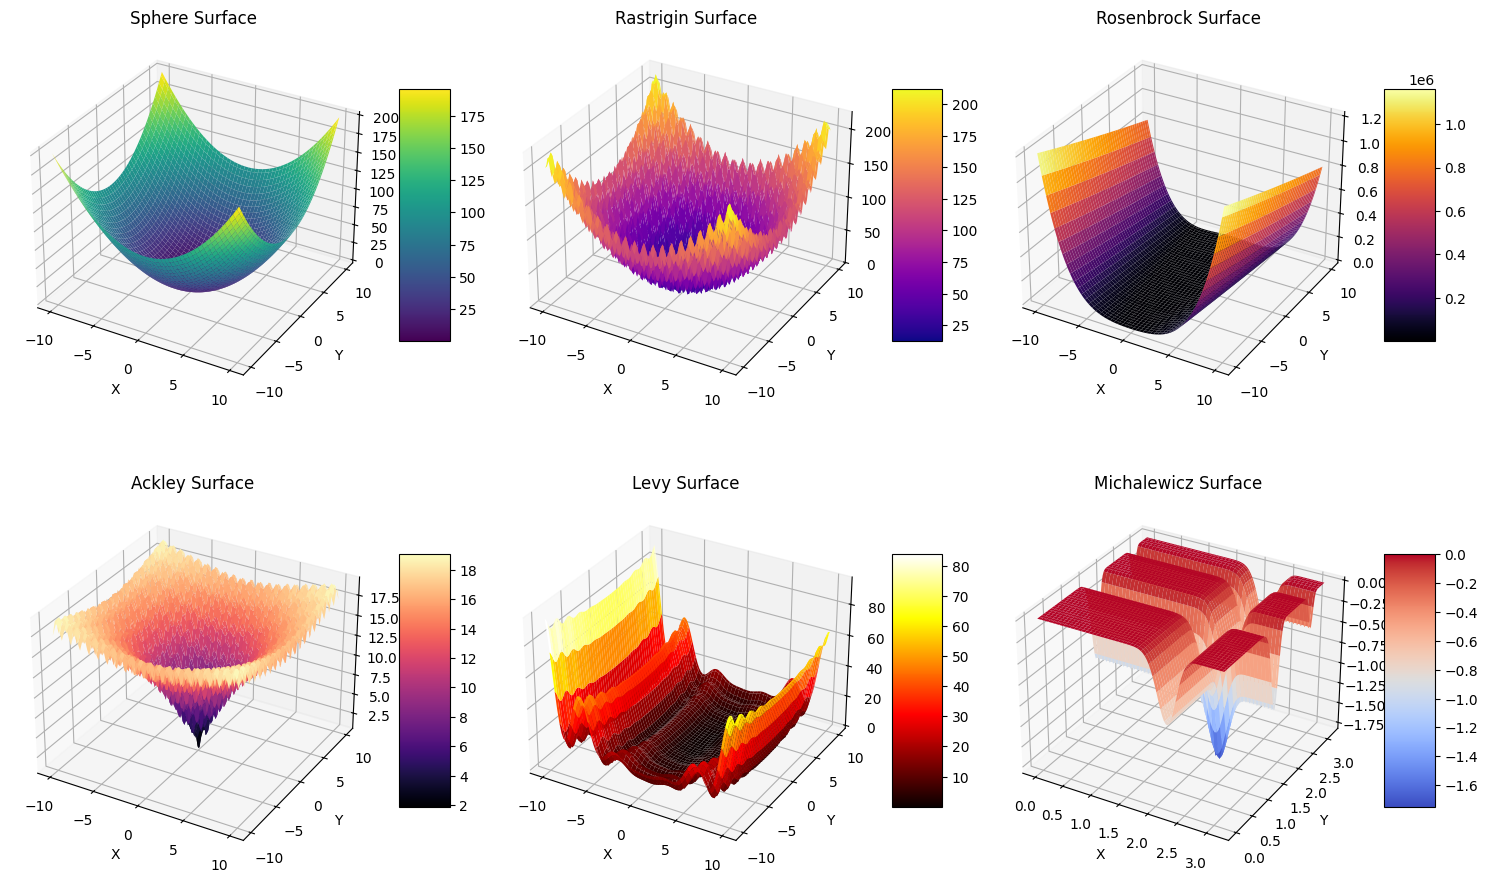

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from mpl_toolkits.mplot3d import Axes3D

# ------------------ Benchmark Functions ------------------

def sphere(x):
    return np.sum(x**2)

def rastrigin(x):
    A = 10.0
    return A * x.size + np.sum(x**2 - A * np.cos(2*pi*x))

def rosenbrock(x):
    return np.sum(100.0*(x[1:] - x[:-1]**2)**2 + (x[:-1]-1.0)**2)

def ackley(x):
    a, b, c = 20.0, 0.2, 2*np.pi
    n = x.size
    return -a*np.exp(-b*np.sqrt(np.sum(x**2)/n)) \
           - np.exp(np.sum(np.cos(c*x))/n) + a + np.e

def levy(x):
    """Lévy function for optimization."""
    w = 1 + (x - 1) / 4  # Transform x to w
    term1 = np.sin(pi * w[0])**2
    term2 = np.sum((w[:-1] - 1)**2 * (1 + 10 * np.sin(pi * w[:-1] + 1)**2))
    term3 = (w[-1] - 1)**2 * (1 + np.sin(2 * pi * w[-1])**2)
    return term1 + term2 + term3

def michalewicz(x, m=10):
    """Michalewicz function for optimization."""
    i = np.arange(1, len(x) + 1)
    return -np.sum(np.sin(x) * np.sin(i * x**2 / pi)**(2 * m))

# ------------------ Utility Functions ------------------

def clip_bounds(x, lb, ub):
    return np.minimum(np.maximum(x, lb), ub)

def unit_random(dim):
    v = np.random.normal(size=dim)
    return v / (np.linalg.norm(v) + 1e-12)

class ScentField:
    """Gaussian-kernel memory of good points. Used for 'scent attraction'."""
    def __init__(self, dim, lb, ub, sigma_frac=0.12, max_pts=300):
        self.dim = dim
        self.lb, self.ub = np.array(lb), np.array(ub)
        self.sigma2 = (sigma_frac * np.linalg.norm(self.ub - self.lb))**2
        self.max_pts = max_pts
        self.pts, self.wts = [], []

    def add(self, x, w=1.0):
        self.pts.append(x.copy()); self.wts.append(float(w))
        if len(self.pts) > self.max_pts:
            self.pts.pop(0); self.wts.pop(0)

    def grad(self, x):
        if not self.pts: return np.zeros_like(x)
        g = np.zeros_like(x, float)
        s2 = self.sigma2 + 1e-12
        for p, w in zip(self.pts, self.wts):
            d = x - p
            e = np.exp(-np.dot(d, d)/(2*s2))
            g += -w * e * d / s2  # attraction (negative gradient)
        return g

def neighborhood_best(pop, fits, i, k=5):
    n = len(pop)
    if n == 1: return pop[i]
    idxs = np.random.choice([j for j in range(n) if j != i],
                            size=min(k, n-1), replace=False)
    j_best = min(idxs, key=lambda j: fits[j])
    return pop[j_best]

# ------------------ Koala Optimization Algorithm ------------------

def koa_optimize(objective, dim, lb, ub,
                 n_pop=30, iters=300,
                 lam1=0.25, lam2=0.25, lam3=0.25,  # eucalyptus pulls
                 alpha0_frac=0.22, alpha_min_frac=0.01, # climb step
                 eta=0.08,  # scent strength
                 p_burst0=0.08, p_burst_min=0.01, # night burst prob
                 L0_frac=0.5, # burst length
                 stagnation_patience=25, reinit_frac=0.15,
                 random_seed=None, return_history=True):

    if random_seed is not None:
        np.random.seed(random_seed)

    lb = np.full(dim, lb, float) if np.isscalar(lb) else np.array(lb, float)
    ub = np.full(dim, ub, float) if np.isscalar(ub) else np.array(ub, float)
    R = np.linalg.norm(ub - lb)

    # initialization
    pop = np.random.uniform(lb, ub, size=(n_pop, dim))
    fits = np.array([objective(x) for x in pop])
    pbest = pop.copy(); pbest_f = fits.copy()
    gi = int(np.argmin(fits)); gbest = pop[gi].copy(); gbest_f = float(fits[gi])

    scent = ScentField(dim, lb, ub)
    for x, f in zip(pop, fits):
        scent.add(x, w=1.0/(1+f if np.isfinite(f) else 1.0))

    hist = []
    no_imp = 0
    alpha_max = alpha0_frac * R
    alpha_min = alpha_min_frac * R
    L0 = L0_frac * R

    for t in range(iters):
        # schedules
        alpha_t = alpha_max - (t/iters) * (alpha_max - alpha_min)
        p_burst = max(p_burst_min, p_burst0 * (1 - 0.7*(t/iters)))
        L_t = max(0.05*R, L0 * (0.5 + 0.5*(1 - t/iters)))

        for i in range(n_pop):
            x = pop[i].copy()

            # 1. climb (greedy exploitation)
            x_try = clip_bounds(x + alpha_t*np.random.normal(size=dim), lb, ub)
            f_try = objective(x_try)
            if f_try < fits[i]: x, fits[i] = x_try, f_try

            # 2. eucalyptus pull
            nb = neighborhood_best(pop, fits, i, k=5)
            x = clip_bounds(x + lam1*(pbest[i]-x) + lam2*(nb-x) + lam3*(gbest-x), lb, ub)

            # 3. scent attraction
            x = clip_bounds(x + eta*scent.grad(x), lb, ub)

            # 4. night burst
            if np.random.rand() < p_burst:
                x = clip_bounds(x + L_t*unit_random(dim), lb, ub)

            # update memory
            f_new = objective(x)
            if f_new < fits[i]:
                pop[i], fits[i] = x, f_new
            if fits[i] < pbest_f[i]:
                pbest[i], pbest_f[i] = pop[i].copy(), fits[i]
                scent.add(pbest[i], w=1.0/(1+fits[i]))
            if fits[i] < gbest_f:
                gbest, gbest_f = pop[i].copy(), float(fits[i])
                no_imp = 0

        hist.append(gbest_f)
        no_imp += 1

        # reseeding worst solutions
        if no_imp > stagnation_patience:
            n_re = max(1, int(reinit_frac * n_pop))
            worst = np.argsort(fits)[-n_re:]
            for j in worst:
                pop[j] = np.random.uniform(lb, ub, size=dim)
                fits[j] = float(objective(pop[j]))
                pbest[j], pbest_f[j] = pop[j].copy(), fits[j]
                scent.add(pop[j], w=1.0/(1+fits[j]))
            no_imp = 0

    if return_history: return gbest, gbest_f, np.array(hist)
    return gbest, gbest_f

# ------------------ Surface Plot Function ------------------

def plot_surface(func, name, lb, ub, colormap, ax):
    """Generate a 3D surface plot for a 2D function."""
    x = np.linspace(lb, ub, 100)
    y = np.linspace(lb, ub, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))
    
    surf = ax.plot_surface(X, Y, Z, cmap=colormap, edgecolor='none')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Fitness')
    ax.set_title(f'{name} Surface')
    return surf

# ------------------ Demo Run ------------------

if __name__ == "__main__":
    # Define benchmark functions and their properties
    funcs = [
        {"name": "Sphere", "func": sphere, "lb": -10.0, "ub": 10.0, "cmap": "viridis"},
        {"name": "Rastrigin", "func": rastrigin, "lb": -10.0, "ub": 10.0, "cmap": "plasma"},
        {"name": "Rosenbrock", "func": rosenbrock, "lb": -10.0, "ub": 10.0, "cmap": "inferno"},
        {"name": "Ackley", "func": ackley, "lb": -10.0, "ub": 10.0, "cmap": "magma"},
        {"name": "Levy", "func": levy, "lb": -10.0, "ub": 10.0, "cmap": "hot"},
        {"name": "Michalewicz", "func": michalewicz, "lb": 0.0, "ub": pi, "cmap": "coolwarm"}
    ]

    # Create subplots for surface plots
    fig = plt.figure(figsize=(15, 10))
    for i, f_info in enumerate(funcs, 1):
        ax = fig.add_subplot(2, 3, i, projection='3d')
        surf = plot_surface(f_info["func"], f_info["name"], f_info["lb"], f_info["ub"], f_info["cmap"], ax)
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()

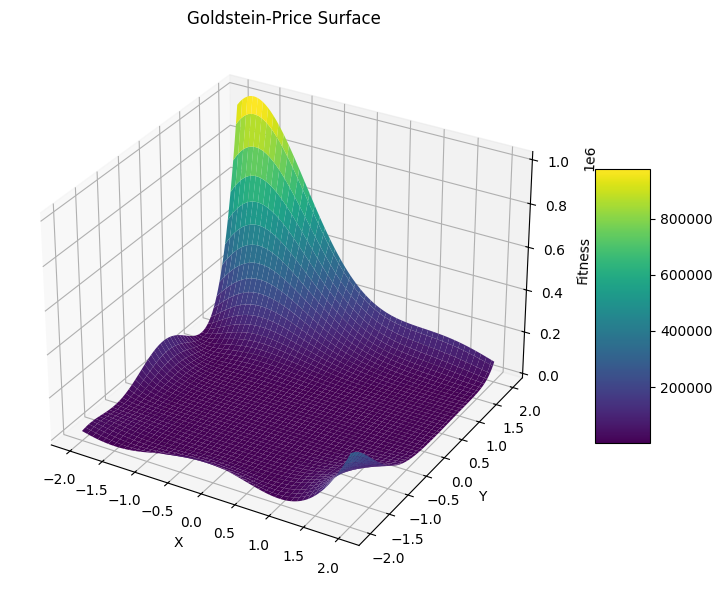

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from mpl_toolkits.mplot3d import Axes3D

# ------------------ Benchmark Functions ------------------

def goldstein_price(x):
    """Goldstein-Price function for optimization."""
    if len(x) != 2:
        raise ValueError("Goldstein-Price function is defined for 2 dimensions only.")
    a = 1 + (x[0] + x[1] + 1)**2 * (19 - 14*x[0] + 3*x[0]**2 - 14*x[1] + 6*x[0]*x[1] + 3*x[1]**2)
    b = 30 + (2*x[0] - 3*x[1])**2 * (18 - 32*x[0] + 12*x[0]**2 + 48*x[1] - 36*x[0]*x[1] + 27*x[1]**2)
    return a * b

# ------------------ Utility Functions ------------------

def clip_bounds(x, lb, ub):
    return np.minimum(np.maximum(x, lb), ub)

def unit_random(dim):
    v = np.random.normal(size=dim)
    return v / (np.linalg.norm(v) + 1e-12)

class ScentField:
    """Gaussian-kernel memory of good points. Used for 'scent attraction'."""
    def __init__(self, dim, lb, ub, sigma_frac=0.12, max_pts=300):
        self.dim = dim
        self.lb, self.ub = np.array(lb), np.array(ub)
        self.sigma2 = (sigma_frac * np.linalg.norm(self.ub - self.lb))**2
        self.max_pts = max_pts
        self.pts, self.wts = [], []

    def add(self, x, w=1.0):
        self.pts.append(x.copy()); self.wts.append(float(w))
        if len(self.pts) > self.max_pts:
            self.pts.pop(0); self.wts.pop(0)

    def grad(self, x):
        if not self.pts: return np.zeros_like(x)
        g = np.zeros_like(x, float)
        s2 = self.sigma2 + 1e-12
        for p, w in zip(self.pts, self.wts):
            d = x - p
            e = np.exp(-np.dot(d, d)/(2*s2))
            g += -w * e * d / s2  # attraction (negative gradient)
        return g

def neighborhood_best(pop, fits, i, k=5):
    n = len(pop)
    if n == 1: return pop[i]
    idxs = np.random.choice([j for j in range(n) if j != i],
                            size=min(k, n-1), replace=False)
    j_best = min(idxs, key=lambda j: fits[j])
    return pop[j_best]

# ------------------ Koala Optimization Algorithm ------------------

def koa_optimize(objective, dim, lb, ub,
                 n_pop=30, iters=300,
                 lam1=0.25, lam2=0.25, lam3=0.25,  # eucalyptus pulls
                 alpha0_frac=0.22, alpha_min_frac=0.01, # climb step
                 eta=0.08,  # scent strength
                 p_burst0=0.08, p_burst_min=0.01, # night burst prob
                 L0_frac=0.5, # burst length
                 stagnation_patience=25, reinit_frac=0.15,
                 random_seed=None, return_history=True):

    if random_seed is not None:
        np.random.seed(random_seed)

    lb = np.full(dim, lb, float) if np.isscalar(lb) else np.array(lb, float)
    ub = np.full(dim, ub, float) if np.isscalar(ub) else np.array(ub, float)
    R = np.linalg.norm(ub - lb)

    # initialization
    pop = np.random.uniform(lb, ub, size=(n_pop, dim))
    fits = np.array([objective(x) for x in pop])
    pbest = pop.copy(); pbest_f = fits.copy()
    gi = int(np.argmin(fits)); gbest = pop[gi].copy(); gbest_f = float(fits[gi])

    scent = ScentField(dim, lb, ub)
    for x, f in zip(pop, fits):
        scent.add(x, w=1.0/(1+f if np.isfinite(f) else 1.0))

    hist = []
    no_imp = 0
    alpha_max = alpha0_frac * R
    alpha_min = alpha_min_frac * R
    L0 = L0_frac * R

    for t in range(iters):
        # schedules
        alpha_t = alpha_max - (t/iters) * (alpha_max - alpha_min)
        p_burst = max(p_burst_min, p_burst0 * (1 - 0.7*(t/iters)))
        L_t = max(0.05*R, L0 * (0.5 + 0.5*(1 - t/iters)))

        for i in range(n_pop):
            x = pop[i].copy()

            # 1. climb (greedy exploitation)
            x_try = clip_bounds(x + alpha_t*np.random.normal(size=dim), lb, ub)
            f_try = objective(x_try)
            if f_try < fits[i]: x, fits[i] = x_try, f_try

            # 2. eucalyptus pull
            nb = neighborhood_best(pop, fits, i, k=5)
            x = clip_bounds(x + lam1*(pbest[i]-x) + lam2*(nb-x) + lam3*(gbest-x), lb, ub)

            # 3. scent attraction
            x = clip_bounds(x + eta*scent.grad(x), lb, ub)

            # 4. night burst
            if np.random.rand() < p_burst:
                x = clip_bounds(x + L_t*unit_random(dim), lb, ub)

            # update memory
            f_new = objective(x)
            if f_new < fits[i]:
                pop[i], fits[i] = x, f_new
            if fits[i] < pbest_f[i]:
                pbest[i], pbest_f[i] = pop[i].copy(), fits[i]
                scent.add(pbest[i], w=1.0/(1+fits[i]))
            if fits[i] < gbest_f:
                gbest, gbest_f = pop[i].copy(), float(fits[i])
                no_imp = 0

        hist.append(gbest_f)
        no_imp += 1

        # reseeding worst solutions
        if no_imp > stagnation_patience:
            n_re = max(1, int(reinit_frac * n_pop))
            worst = np.argsort(fits)[-n_re:]
            for j in worst:
                pop[j] = np.random.uniform(lb, ub, size=dim)
                fits[j] = float(objective(pop[j]))
                pbest[j], pbest_f[j] = pop[j].copy(), fits[j]
                scent.add(pop[j], w=1.0/(1+fits[j]))
            no_imp = 0

    if return_history: return gbest, gbest_f, np.array(hist)
    return gbest, gbest_f

# ------------------ Surface Plot Function ------------------

def plot_surface(func, name, lb, ub, colormap, ax):
    """Generate a 3D surface plot for a 2D function."""
    x = np.linspace(lb, ub, 100)
    y = np.linspace(lb, ub, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))
    
    surf = ax.plot_surface(X, Y, Z, cmap=colormap, edgecolor='none')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Fitness')
    ax.set_title(f'{name} Surface')
    return surf

# ------------------ Demo Run ------------------

if __name__ == "__main__":
    # Define Goldstein-Price function and its properties
    func_info = {"name": "Goldstein-Price", "func": goldstein_price, "lb": -2.0, "ub": 2.0, "cmap": "viridis"}

    # Create figure for surface plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    surf = plot_surface(func_info["func"], func_info["name"], func_info["lb"], func_info["ub"], func_info["cmap"], ax)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()

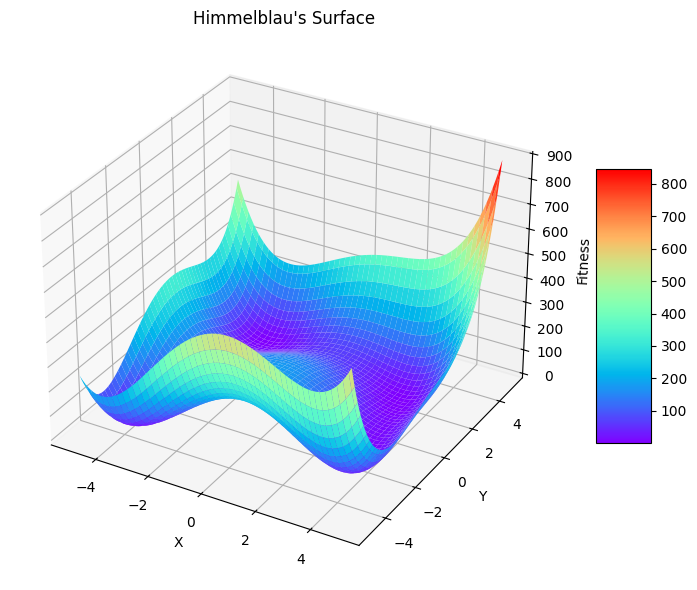

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from mpl_toolkits.mplot3d import Axes3D

# ------------------ Benchmark Functions ------------------

def himmelblau(x):
    """Himmelblau's function for optimization."""
    if len(x) != 2:
        raise ValueError("Himmelblau's function is defined for 2 dimensions only.")
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

# ------------------ Utility Functions ------------------

def clip_bounds(x, lb, ub):
    return np.minimum(np.maximum(x, lb), ub)

def unit_random(dim):
    v = np.random.normal(size=dim)
    return v / (np.linalg.norm(v) + 1e-12)

class ScentField:
    """Gaussian-kernel memory of good points. Used for 'scent attraction'."""
    def __init__(self, dim, lb, ub, sigma_frac=0.12, max_pts=300):
        self.dim = dim
        self.lb, self.ub = np.array(lb), np.array(ub)
        self.sigma2 = (sigma_frac * np.linalg.norm(self.ub - self.lb))**2
        self.max_pts = max_pts
        self.pts, self.wts = [], []

    def add(self, x, w=1.0):
        self.pts.append(x.copy()); self.wts.append(float(w))
        if len(self.pts) > self.max_pts:
            self.pts.pop(0); self.wts.pop(0)

    def grad(self, x):
        if not self.pts: return np.zeros_like(x)
        g = np.zeros_like(x, float)
        s2 = self.sigma2 + 1e-12
        for p, w in zip(self.pts, self.wts):
            d = x - p
            e = np.exp(-np.dot(d, d)/(2*s2))
            g += -w * e * d / s2  # attraction (negative gradient)
        return g

def neighborhood_best(pop, fits, i, k=5):
    n = len(pop)
    if n == 1: return pop[i]
    idxs = np.random.choice([j for j in range(n) if j != i],
                            size=min(k, n-1), replace=False)
    j_best = min(idxs, key=lambda j: fits[j])
    return pop[j_best]

# ------------------ Koala Optimization Algorithm ------------------

def koa_optimize(objective, dim, lb, ub,
                 n_pop=30, iters=300,
                 lam1=0.25, lam2=0.25, lam3=0.25,  # eucalyptus pulls
                 alpha0_frac=0.22, alpha_min_frac=0.01, # climb step
                 eta=0.08,  # scent strength
                 p_burst0=0.08, p_burst_min=0.01, # night burst prob
                 L0_frac=0.5, # burst length
                 stagnation_patience=25, reinit_frac=0.15,
                 random_seed=None, return_history=True):

    if random_seed is not None:
        np.random.seed(random_seed)

    lb = np.full(dim, lb, float) if np.isscalar(lb) else np.array(lb, float)
    ub = np.full(dim, ub, float) if np.isscalar(ub) else np.array(ub, float)
    R = np.linalg.norm(ub - lb)

    # initialization
    pop = np.random.uniform(lb, ub, size=(n_pop, dim))
    fits = np.array([objective(x) for x in pop])
    pbest = pop.copy(); pbest_f = fits.copy()
    gi = int(np.argmin(fits)); gbest = pop[gi].copy(); gbest_f = float(fits[gi])

    scent = ScentField(dim, lb, ub)
    for x, f in zip(pop, fits):
        scent.add(x, w=1.0/(1+f if np.isfinite(f) else 1.0))

    hist = []
    no_imp = 0
    alpha_max = alpha0_frac * R
    alpha_min = alpha_min_frac * R
    L0 = L0_frac * R

    for t in range(iters):
        # schedules
        alpha_t = alpha_max - (t/iters) * (alpha_max - alpha_min)
        p_burst = max(p_burst_min, p_burst0 * (1 - 0.7*(t/iters)))
        L_t = max(0.05*R, L0 * (0.5 + 0.5*(1 - t/iters)))

        for i in range(n_pop):
            x = pop[i].copy()

            # 1. climb (greedy exploitation)
            x_try = clip_bounds(x + alpha_t*np.random.normal(size=dim), lb, ub)
            f_try = objective(x_try)
            if f_try < fits[i]: x, fits[i] = x_try, f_try

            # 2. eucalyptus pull
            nb = neighborhood_best(pop, fits, i, k=5)
            x = clip_bounds(x + lam1*(pbest[i]-x) + lam2*(nb-x) + lam3*(gbest-x), lb, ub)

            # 3. scent attraction
            x = clip_bounds(x + eta*scent.grad(x), lb, ub)

            # 4. night burst
            if np.random.rand() < p_burst:
                x = clip_bounds(x + L_t*unit_random(dim), lb, ub)

            # update memory
            f_new = objective(x)
            if f_new < fits[i]:
                pop[i], fits[i] = x, f_new
            if fits[i] < pbest_f[i]:
                pbest[i], pbest_f[i] = pop[i].copy(), fits[i]
                scent.add(pbest[i], w=1.0/(1+fits[i]))
            if fits[i] < gbest_f:
                gbest, gbest_f = pop[i].copy(), float(fits[i])
                no_imp = 0

        hist.append(gbest_f)
        no_imp += 1

        # reseeding worst solutions
        if no_imp > stagnation_patience:
            n_re = max(1, int(reinit_frac * n_pop))
            worst = np.argsort(fits)[-n_re:]
            for j in worst:
                pop[j] = np.random.uniform(lb, ub, size=dim)
                fits[j] = float(objective(pop[j]))
                pbest[j], pbest_f[j] = pop[j].copy(), fits[j]
                scent.add(pop[j], w=1.0/(1+fits[j]))
            no_imp = 0

    if return_history: return gbest, gbest_f, np.array(hist)
    return gbest, gbest_f

# ------------------ Surface Plot Function ------------------

def plot_surface(func, name, lb, ub, colormap, ax):
    """Generate a 3D surface plot for a 2D function."""
    x = np.linspace(lb, ub, 100)
    y = np.linspace(lb, ub, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))
    
    surf = ax.plot_surface(X, Y, Z, cmap=colormap, edgecolor='none')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Fitness')
    ax.set_title(f'{name} Surface')
    return surf

# ------------------ Demo Run ------------------

if __name__ == "__main__":
    # Define Himmelblau's function and its properties
    func_info = {"name": "Himmelblau's", "func": himmelblau, "lb": -5.0, "ub": 5.0, "cmap": "rainbow"}

    # Create figure for surface plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    surf = plot_surface(func_info["func"], func_info["name"], func_info["lb"], func_info["ub"], func_info["cmap"], ax)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()

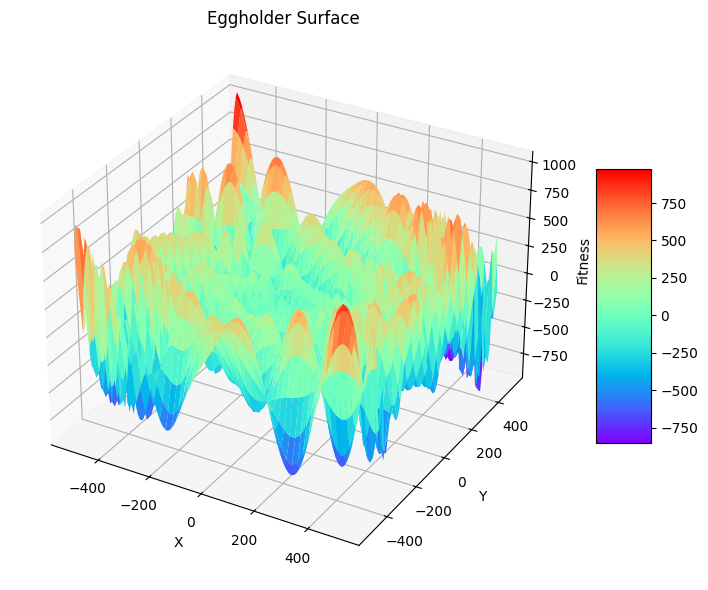

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from mpl_toolkits.mplot3d import Axes3D

# ------------------ Benchmark Functions ------------------

def eggholder(x):
    """Eggholder function for optimization."""
    if len(x) != 2:
        raise ValueError("Eggholder function is defined for 2 dimensions only.")
    term1 = -(x[1] + 47) * np.sin(np.sqrt(np.abs(x[1] + x[0]/2 + 47)))
    term2 = -x[0] * np.sin(np.sqrt(np.abs(x[0] - (x[1] + 47))))
    return term1 + term2

# ------------------ Utility Functions ------------------

def clip_bounds(x, lb, ub):
    return np.minimum(np.maximum(x, lb), ub)

def unit_random(dim):
    v = np.random.normal(size=dim)
    return v / (np.linalg.norm(v) + 1e-12)

class ScentField:
    """Gaussian-kernel memory of good points. Used for 'scent attraction'."""
    def __init__(self, dim, lb, ub, sigma_frac=0.12, max_pts=300):
        self.dim = dim
        self.lb, self.ub = np.array(lb), np.array(ub)
        self.sigma2 = (sigma_frac * np.linalg.norm(self.ub - self.lb))**2
        self.max_pts = max_pts
        self.pts, self.wts = [], []

    def add(self, x, w=1.0):
        self.pts.append(x.copy()); self.wts.append(float(w))
        if len(self.pts) > self.max_pts:
            self.pts.pop(0); self.wts.pop(0)

    def grad(self, x):
        if not self.pts: return np.zeros_like(x)
        g = np.zeros_like(x, float)
        s2 = self.sigma2 + 1e-12
        for p, w in zip(self.pts, self.wts):
            d = x - p
            e = np.exp(-np.dot(d, d)/(2*s2))
            g += -w * e * d / s2  # attraction (negative gradient)
        return g

def neighborhood_best(pop, fits, i, k=5):
    n = len(pop)
    if n == 1: return pop[i]
    idxs = np.random.choice([j for j in range(n) if j != i],
                            size=min(k, n-1), replace=False)
    j_best = min(idxs, key=lambda j: fits[j])
    return pop[j_best]

# ------------------ Koala Optimization Algorithm ------------------

def koa_optimize(objective, dim, lb, ub,
                 n_pop=30, iters=300,
                 lam1=0.25, lam2=0.25, lam3=0.25,  # eucalyptus pulls
                 alpha0_frac=0.22, alpha_min_frac=0.01, # climb step
                 eta=0.08,  # scent strength
                 p_burst0=0.08, p_burst_min=0.01, # night burst prob
                 L0_frac=0.5, # burst length
                 stagnation_patience=25, reinit_frac=0.15,
                 random_seed=None, return_history=True):

    if random_seed is not None:
        np.random.seed(random_seed)

    lb = np.full(dim, lb, float) if np.isscalar(lb) else np.array(lb, float)
    ub = np.full(dim, ub, float) if np.isscalar(ub) else np.array(ub, float)
    R = np.linalg.norm(ub - lb)

    # initialization
    pop = np.random.uniform(lb, ub, size=(n_pop, dim))
    fits = np.array([objective(x) for x in pop])
    pbest = pop.copy(); pbest_f = fits.copy()
    gi = int(np.argmin(fits)); gbest = pop[gi].copy(); gbest_f = float(fits[gi])

    scent = ScentField(dim, lb, ub)
    for x, f in zip(pop, fits):
        scent.add(x, w=1.0/(1+f if np.isfinite(f) else 1.0))

    hist = []
    no_imp = 0
    alpha_max = alpha0_frac * R
    alpha_min = alpha_min_frac * R
    L0 = L0_frac * R

    for t in range(iters):
        # schedules
        alpha_t = alpha_max - (t/iters) * (alpha_max - alpha_min)
        p_burst = max(p_burst_min, p_burst0 * (1 - 0.7*(t/iters)))
        L_t = max(0.05*R, L0 * (0.5 + 0.5*(1 - t/iters)))

        for i in range(n_pop):
            x = pop[i].copy()

            # 1. climb (greedy exploitation)
            x_try = clip_bounds(x + alpha_t*np.random.normal(size=dim), lb, ub)
            f_try = objective(x_try)
            if f_try < fits[i]: x, fits[i] = x_try, f_try

            # 2. eucalyptus pull
            nb = neighborhood_best(pop, fits, i, k=5)
            x = clip_bounds(x + lam1*(pbest[i]-x) + lam2*(nb-x) + lam3*(gbest-x), lb, ub)

            # 3. scent attraction
            x = clip_bounds(x + eta*scent.grad(x), lb, ub)

            # 4. night burst
            if np.random.rand() < p_burst:
                x = clip_bounds(x + L_t*unit_random(dim), lb, ub)

            # update memory
            f_new = objective(x)
            if f_new < fits[i]:
                pop[i], fits[i] = x, f_new
            if fits[i] < pbest_f[i]:
                pbest[i], pbest_f[i] = pop[i].copy(), fits[i]
                scent.add(pbest[i], w=1.0/(1+fits[i]))
            if fits[i] < gbest_f:
                gbest, gbest_f = pop[i].copy(), float(fits[i])
                no_imp = 0

        hist.append(gbest_f)
        no_imp += 1

        # reseeding worst solutions
        if no_imp > stagnation_patience:
            n_re = max(1, int(reinit_frac * n_pop))
            worst = np.argsort(fits)[-n_re:]
            for j in worst:
                pop[j] = np.random.uniform(lb, ub, size=dim)
                fits[j] = float(objective(pop[j]))
                pbest[j], pbest_f[j] = pop[j].copy(), fits[j]
                scent.add(pop[j], w=1.0/(1+fits[j]))
            no_imp = 0

    if return_history: return gbest, gbest_f, np.array(hist)
    return gbest, gbest_f

# ------------------ Surface Plot Function ------------------

def plot_surface(func, name, lb, ub, colormap, ax):
    """Generate a 3D surface plot for a 2D function."""
    x = np.linspace(lb, ub, 100)
    y = np.linspace(lb, ub, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))
    
    surf = ax.plot_surface(X, Y, Z, cmap=colormap, edgecolor='none')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Fitness')
    ax.set_title(f'{name} Surface')
    return surf

# ------------------ Demo Run ------------------

if __name__ == "__main__":
    # Define Eggholder function and its properties
    func_info = {"name": "Eggholder", "func": eggholder, "lb": -512.0, "ub": 512.0, "cmap": "rainbow"}

    # Create figure for surface plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    surf = plot_surface(func_info["func"], func_info["name"], func_info["lb"], func_info["ub"], func_info["cmap"], ax)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()